In [1]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")

# Extra settings
seed = 42
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

## Load the dataset and quick preview

In [3]:
bitcoin = pd.read_csv('../dataset/BTC-EUR.csv', index_col='Date',parse_dates=True)
bitcoin.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-18,9253.401367,9316.917969,9240.340820,9246.486328,9246.486328,1.466026e+10
2019-09-19,9248.524414,9319.454102,8917.574219,9292.973633,9292.973633,1.804724e+10
2019-09-20,9292.886719,9334.069336,9194.604492,9239.483398,9239.483398,1.337076e+10
2019-09-21,9241.304688,9245.341797,9075.292969,9092.541992,9092.541992,1.218296e+10
2019-09-22,9096.534180,9142.628906,9004.768555,9138.951172,9138.951172,1.197878e+10


In [3]:
 bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 733 entries, 2019-09-18 to 2021-09-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       728 non-null    float64
 1   High       728 non-null    float64
 2   Low        728 non-null    float64
 3   Close      728 non-null    float64
 4   Adj Close  728 non-null    float64
 5   Volume     728 non-null    float64
dtypes: float64(6)
memory usage: 40.1 KB


In [4]:
bitcoin.describe()

,Open,High,Low,Close,Adj Close,Volume
count,728.000000,728.000000,728.000000,728.000000,728.000000,7.280000e+02
mean,19197.673288,19730.379456,18615.902011,19238.221593,19238.221593,3.220361e+10
std,14523.420277,14970.825356,14001.387073,14539.192653,14539.192653,1.787030e+10
min,4482.425293,4825.007324,3672.950928,4444.237305,4444.237305,1.072016e+10
25%,8066.323243,8193.060913,7963.511596,8066.371460,8066.371460,2.006816e+10
50%,9693.900390,9822.947265,9541.995118,9695.412110,9695.412110,2.923017e+10
75%,30483.918457,31672.124024,29104.587402,30546.437012,30546.437012,4.047004e+10
max,53140.605469,54238.394531,51988.964844,53123.628906,53123.628906,2.907271e+11


In [5]:
bitcoin.isnull().sum()


Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [6]:
bitcoin.dropna(axis=0,inplace =True)
bitcoin.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Lets check each feature values

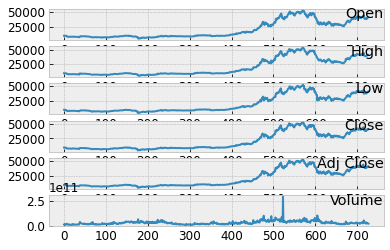

In [7]:
values = bitcoin.values
groups = [0, 1, 2, 3, 4, 5,]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(bitcoin.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

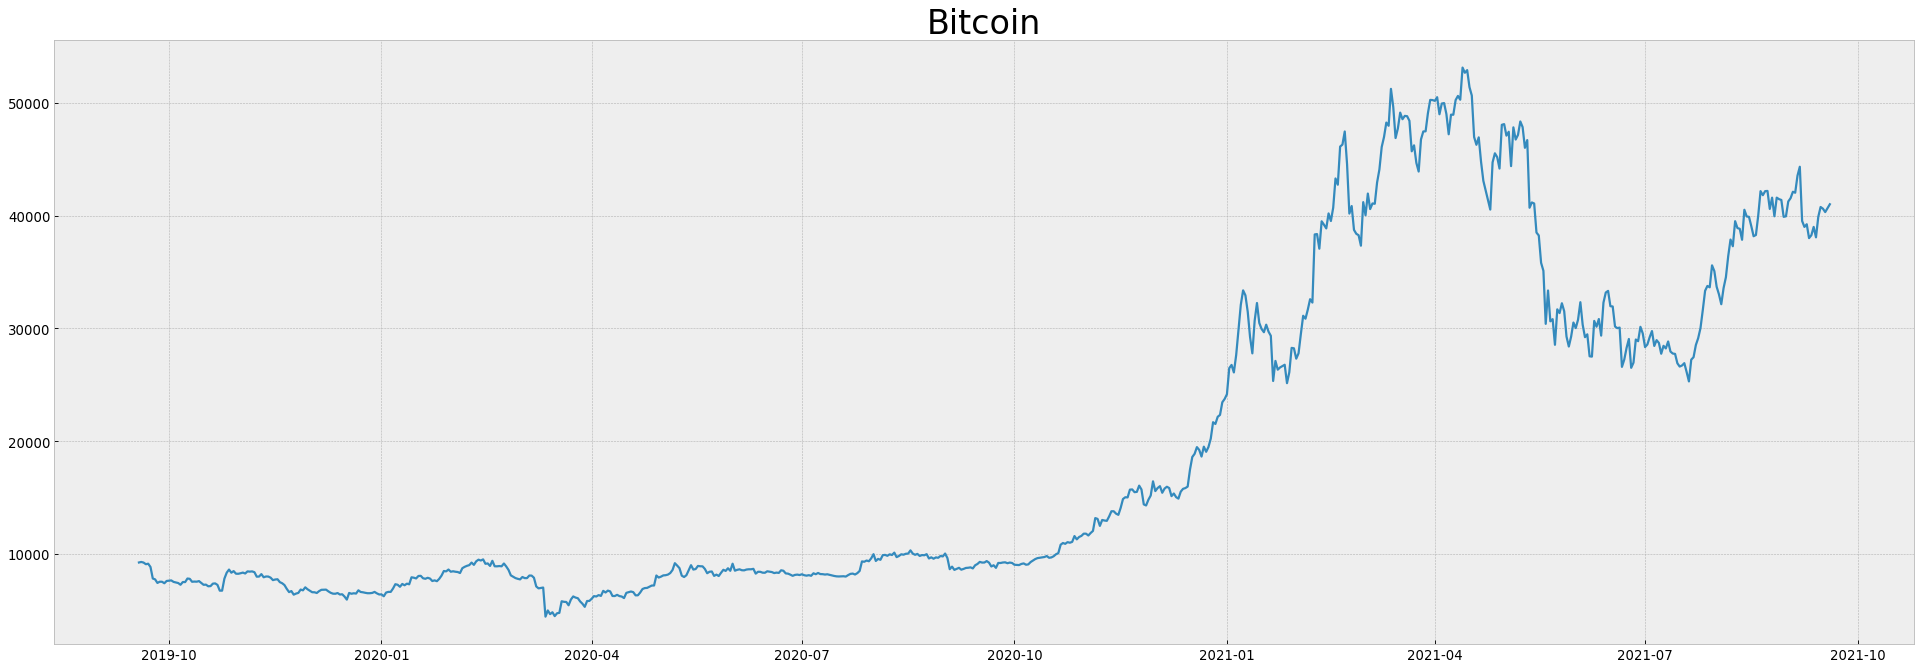

In [8]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Bitcoin', fontsize=30)

plt.plot(bitcoin.Close)


We notice that it is better to split the seire in two years data  in our analysis. 

## Decomposing our time series

##### Additive Model
`y(t) = Level + Trend + Seasonality + Noise`



##### Multiplicative model
`y(t) = Level * Trend * Seasonality * Noise`



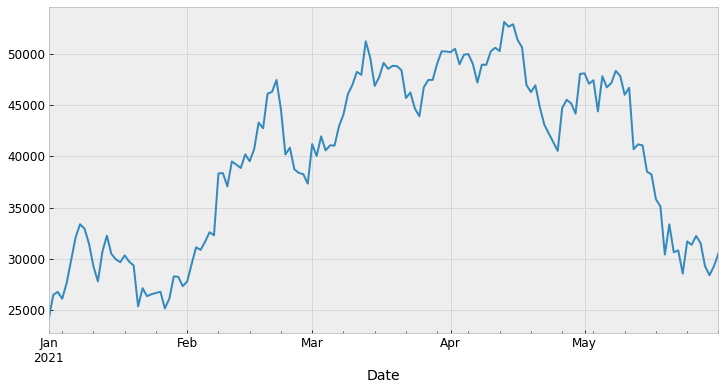

In [9]:
plt.figure(figsize=(12,6))
bitcoin['2021-1':'2021-5']['Close'].plot()
plt.show()

Our model is more likely to be multiplicative because the trend is not linear and the seasonality is not constant

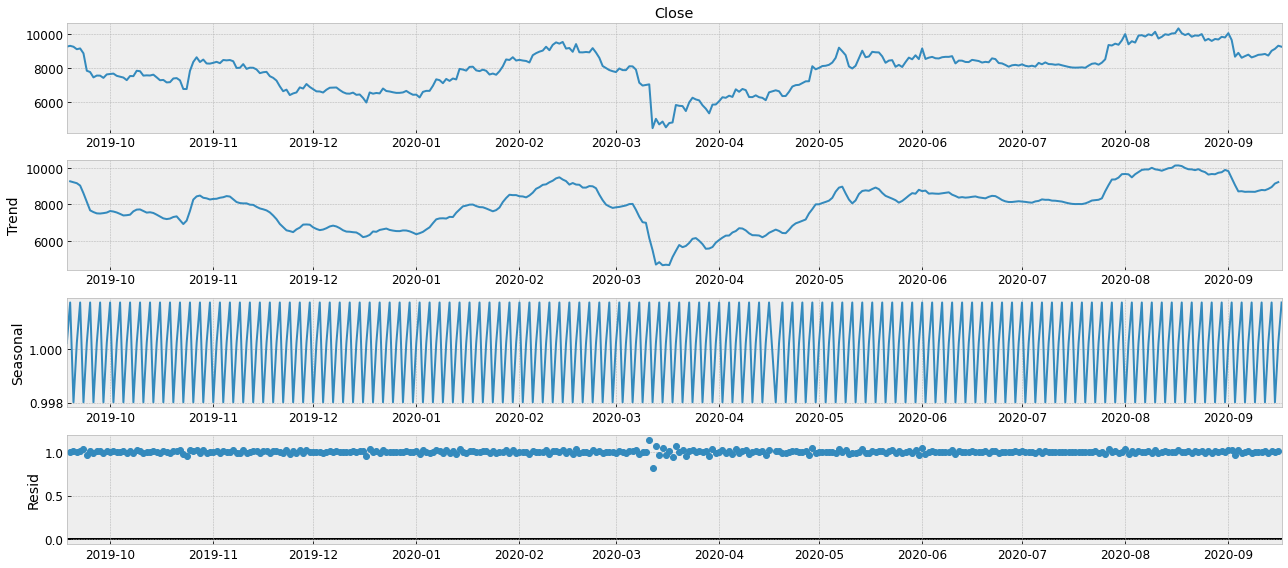

<Figure size 4000x1600 with 0 Axes>

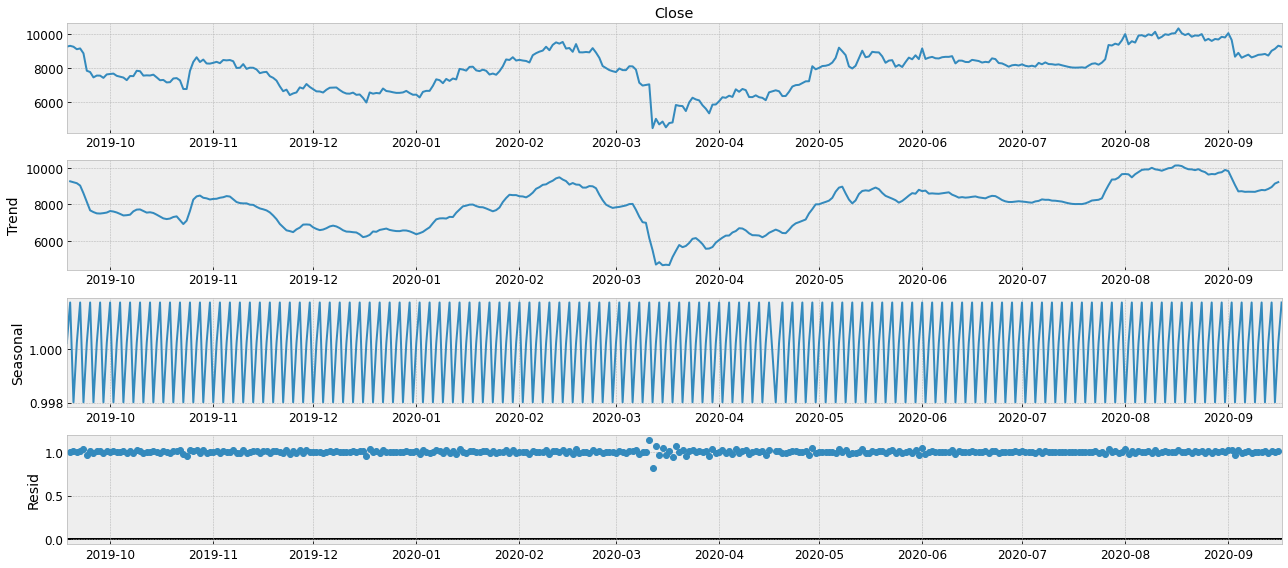

In [10]:
# Decomposition for the firt year of data.
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = bitcoin.Close[:365]
result = seasonal_decompose(series, model='multiplicative',period=3)
result.plot()

### Trend

Now we will try some methods to check for trend in our series:
* Automatic decomposing
* Moving average
* Fit a linear regression model to identify trend

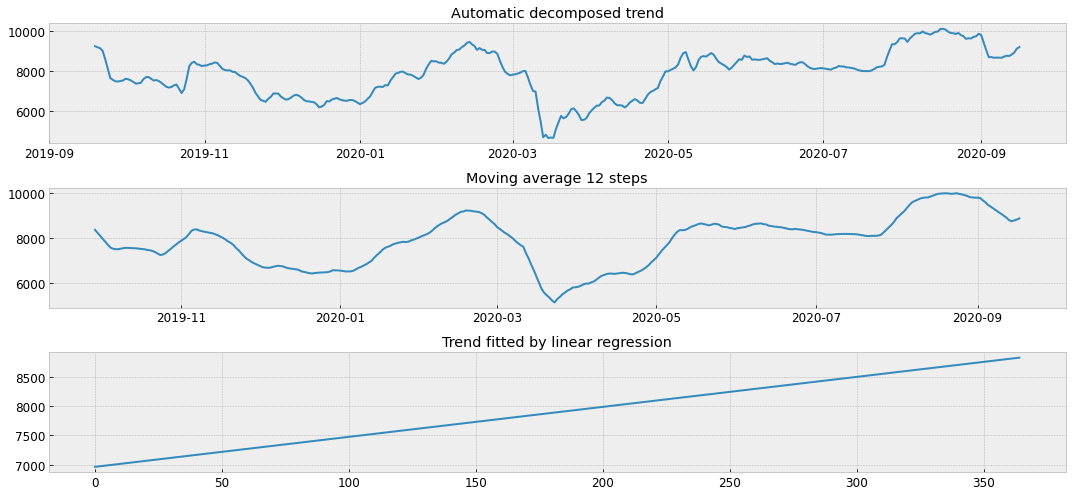

In [11]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = bitcoin.Close[:365].rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, 365)]
X = np.reshape(X, (len(X), 1))
y = bitcoin.Close[:365].values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

We can see our series (first year data) does not have a strong trend, results from both the automatic decomposition and the moving average look more like a seasonality effect+random noise than a trend. This sort of confirmed with our linear regression, which cant find our series properly and gives us a poor trend.

Let's check the last year data.

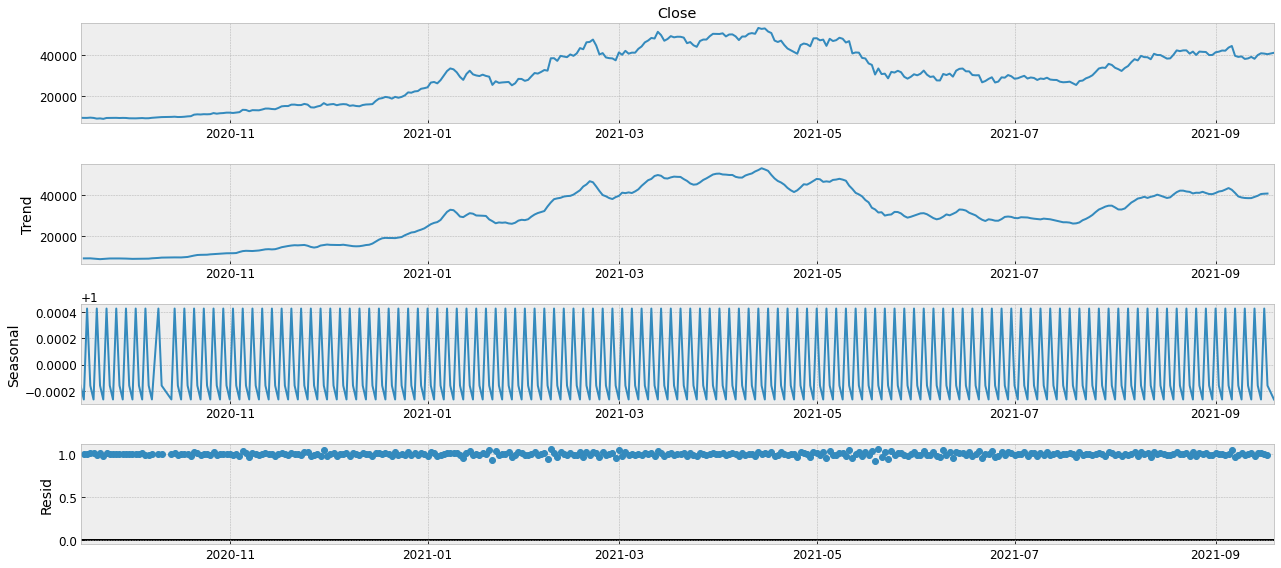

<Figure size 4000x1600 with 0 Axes>

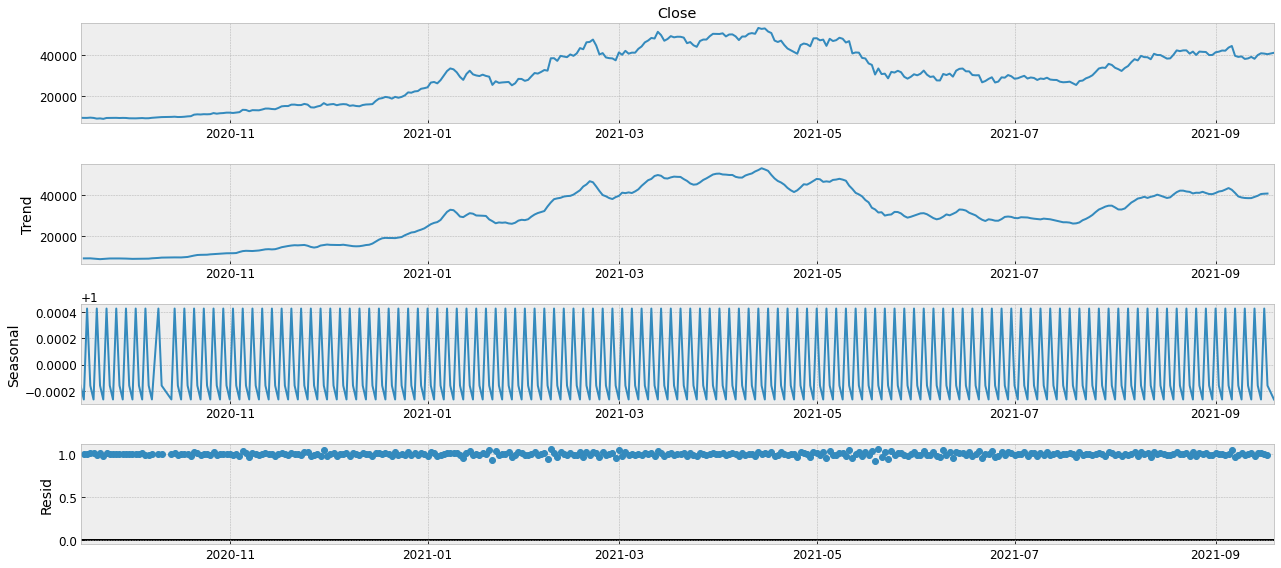

In [12]:
# Decomposition for the last year of data.
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = bitcoin.Close[-365:]
result = seasonal_decompose(series, model='multiplicative', period=3)
result.plot()

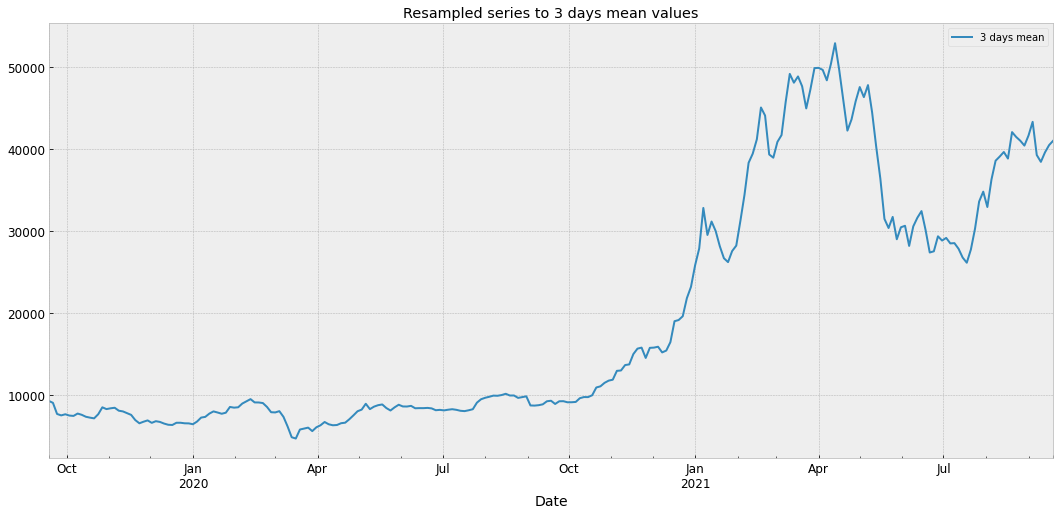

In [13]:
# Looking for 3 days seasonality
resample = bitcoin.resample('3D')
resample_mean = resample.mean()
resample_mean.Close.plot(label='3 days mean')
plt.title("Resampled series to 3 days mean values")
plt.legend()


In the continuation of our a analysis we will use the the last year data of the series.

### Noise

Our time series will also have a noise component to them, most likely [white noise](https://en.wikipedia.org/wiki/White_noise). We say white noise is present if the measurement are independent and identically distributed with a mean of zero. This will mean all our measurements have same variance and no correlation with the rest of values in the series.

If our time series has white noise this will mean we can't predict that component of the series (as is random) and we shoul aim to produce a model with errors close to this white noise.

How to check if our series has white noise?
* Check our series histogram, does it look like a Gaussian distribution? Mean=0 and constand std
* Correlation plots
* Standard deviation distribution, is it a Gaussian distribution?
* Does the mean or level change over time?

Text(0.5, 1.0, 'Mean over time')

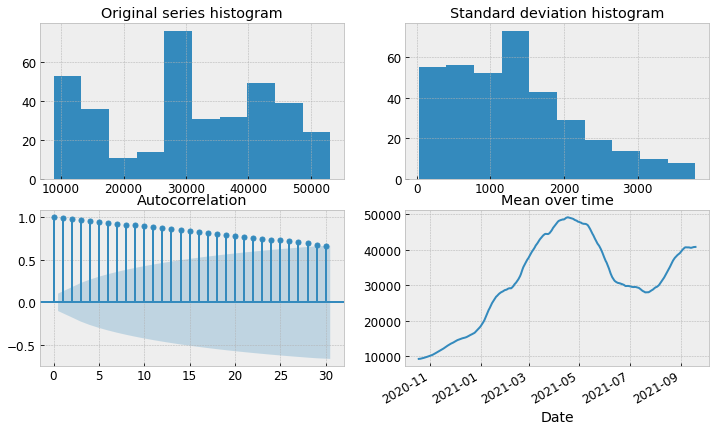

In [14]:
series = bitcoin.Close[-365:].values

fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

bitcoin.Close[-365:].hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = bitcoin.Close[-365:].rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = bitcoin.Close[-365:].rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

We can see our series  follow a Gaussian distribution from the histogram and neither the standard deviation but both of them  do have the mean centered which shows a small part of white noise 
We also have a  correlation with  measurements in time.
The mean over time also changes .
We could say our series does contain a small part of white noise.

## Stationarity
Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.



### Check for sationarity

### Autocorrelation and Partial autocorrelation plots

Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.

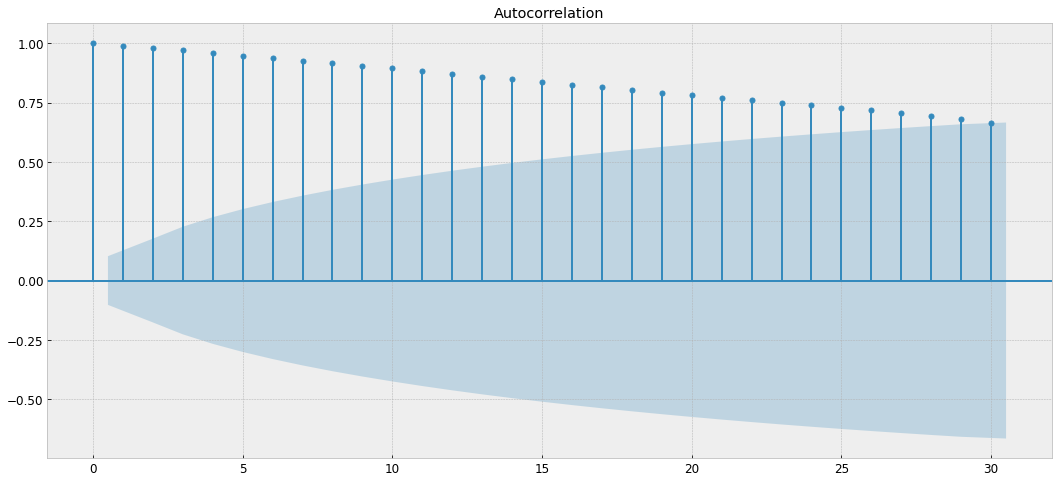

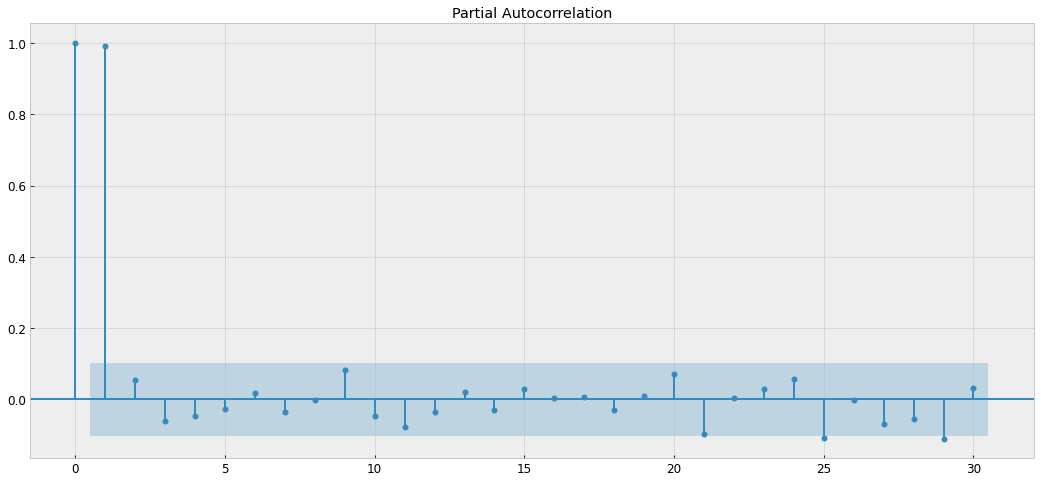

In [15]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

We saw that our time series values are correlated with distant points in time, this is good and shows us our series should be non-stationary but for the shake of learning and confirming we will test with some other methods.

### Rolling means and standard deviation of our series

We were talking about how our mean and standard deviation should be constant over time in order to have a stationary time series, why not just plot this two properties?

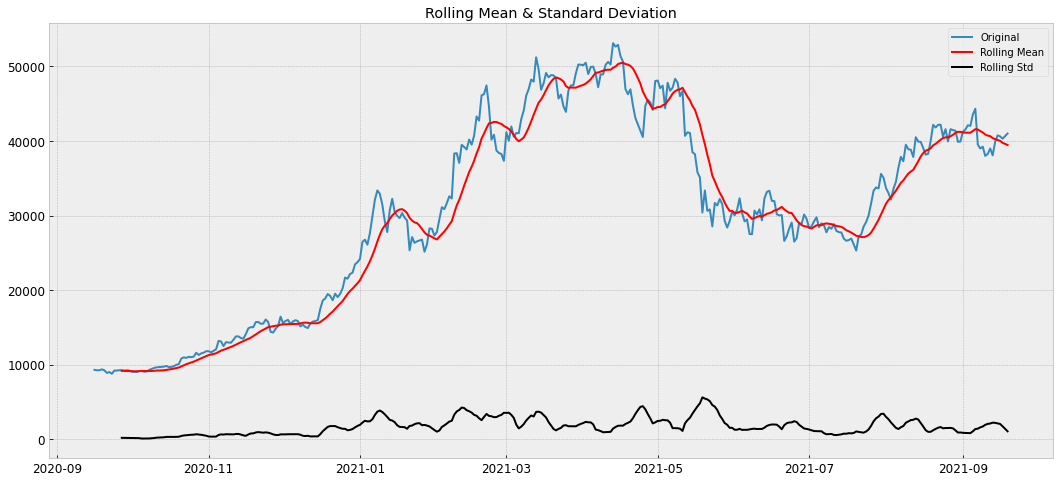

In [16]:
# Determing rolling statistics
rolmean = bitcoin.Close[-365:].rolling(window=12).mean()
rolstd = bitcoin.Close[-365:].rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(bitcoin.Close[-365:], label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

We can see how our standar deviation has almost a constant behaviour in this year but the mean has not a constant behaviour in that year(2020-2021). We will check the augmented dickey-fuller test

### Augmented Dickey-Fuller test
The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.


p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [17]:
X = bitcoin.Close[-365:].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.529313
p-value: 0.518964
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


The p_value > 0.05 , so we can not reject the null hypothesis that the series is not stationary.

## Making Time Series Stationary

### Difference transform

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

`difference(t) = observation(t) - observation(t-1)`

Taking the difference between consecutive observations would be a lag-1 difference, we can tweek this lag value to fit our series.

We can also apply differencing transforms consecutively in the same series if the temporal effect hasnt been removed yet. This is called multiple order difference transform

In [18]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset = diff
    return diff

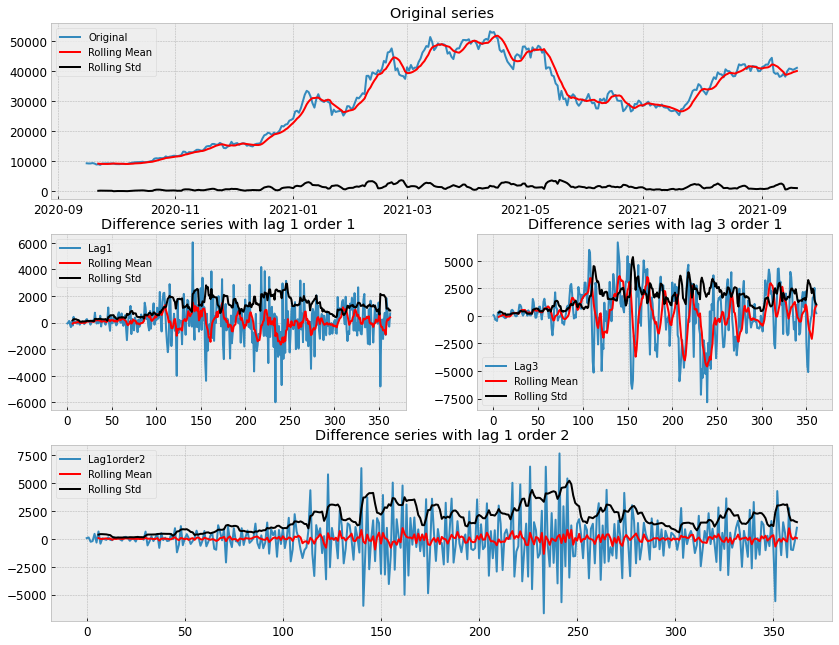

In [19]:
lag1series = pd.Series(difference(bitcoin.Close[-365:], interval=1, order=1))
lag3series = pd.Series(difference(bitcoin.Close[-365:], interval=3, order=1))
lag1order2series = pd.Series(difference(
    series, interval=1, order=2))
    

fig = plt.figure(figsize=(14, 11))
layout = (3, 2)
original = plt.subplot2grid(layout, (0, 0), colspan=2)
lag1 = plt.subplot2grid(layout, (1, 0))
lag3 = plt.subplot2grid(layout, (1, 1))
lag1order2 = plt.subplot2grid(layout, (2, 0), colspan=2)

original.set_title('Original series')
original.plot(bitcoin.Close[-365:], label='Original')
original.plot(bitcoin.Close[-365:].rolling(
    7).mean(), color='red', label='Rolling Mean')
original.plot(bitcoin.Close[-365:].rolling(7).std(),
              color='black', label='Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label="Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label='Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label="Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label='Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label="Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(),
                color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(),
                color='black', label='Rolling Std')
lag1order2.legend(loc='best')



We can see how   differencing does really remove stationary and once we go with order 2 difference it looks the most stationary one

In [20]:
X = lag1series
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -20.514638
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


## forcasting

We are interested in attempting to forecast the Close series.  We'll go ahead and define an utility function that let us extract  the last $n$ days of data.


In [21]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-n_days:] 



#### Train a simple RNN to forecast the Close time series

Before we can train a neural network with keras, we need to process the data into a format that the library accepts. In particular, for keras RNNs and LSTMs, training samples should be stored in a 3D numpy array of shape **(n_samples, time_steps, n_features)**. Since we'll be using only the series' history to predict its future, we'll only have 1 feature. Also, for the next-step prediction that we'll do in this notebook, target values can be stored in a simple list.

To this end, we define utility functions that allow us to extract the formatted data. The **get_train_test_data** function gives us the flexibility to define the length of the extracted training and test sequences and the number of time steps to use for prediction -- we'll run simple tests of our models by holding out the end of the extracted sequence and generating predictions to compare against the ground truth.

In [22]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_days, 
                        test_days, sample_gap=3):
    """
    Utility processing function that splits an daily time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_days (int): length of sequence input to network 
    test_days (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 3
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values

    train = forecast_series[:-test_days]
    test = forecast_series[-test_days:]

    train_X, train_y = [], []

    for i in range(0, train.shape[0]-input_days, sample_gap):
        train_X.append(train[i:i+input_days])
        train_y.append(train[i+input_days])

    train_X = get_keras_format_series(train_X)    
    train_y= np.array(train_y).reshape(-1,1) 
    test_X = test[:input_days]
    test_y = test[input_days:]
    
    return train_X, test_X, train_y, test_y

With the **get_train_test_data** utility function in hand, we're all set to extract keras-friendly arrays and start training simple RNN models. We run this function in the cell below. We use the last 728 days of the Close series, and will train a model that takes in 12 time steps in order to predict the next time step. We use the last day of data for visually testing the model. 

In [23]:
series_days = 365
input_days = 12
test_days = 24
sample_gap = 1

train_X, test_X, train_y, test_y = \
    (get_train_test_data(bitcoin, 'Close', series_days, 
                         input_days, test_days, sample_gap))


Below we see that by taking multiple time slices, we get 231 training samples of 12 time steps each. 

In [24]:
print('Training shape: {}'.format(train_X.shape))


Training shape: (329, 12, 1)


And now we're ready to train! Since we'd like to repeatedly adjust our model's hyperparameters to see what works best, we'll write a reusable function for training a simple RNN model using keras.

In [35]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    model.add(Dense(256))
    model.add(Dense(64)) 
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=12, verbose=0)
    
    return model

Great, now let's use this function to fit a very simple baseline model.

In [36]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

Now we need to actually extract multi-step predictions from this model, as it was trained to predict only one future time step. For multi-step forecasting, we'll iteratively generate one prediction, append it to the end of the input sequence (and shift that sequence forward by one step), then feed the new sequence back to the model. We stop once we've generated all the time step predictions we need.

This prediction method and a utility function for plotting its output against the ground truth are defined below.

In [37]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:]
        X_init[:,-1,:] = pred
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(X_init, n_steps=len(y), model=model) 
    
    start_range = range(1, input_days+1)
    predict_range = range(input_days, test_days) 
    
    plt.figure(figsize=(12,6))
    plt.style.use('fivethirtyeight')
    plt.plot(start_range, X_init)
    plt.plot(predict_range, y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

Ok, we've finally arrived at the time to see how our baseline model does. We can simply run the **predict_and_plot** function on the extracted test data as below, and inspect the resulting plot. 

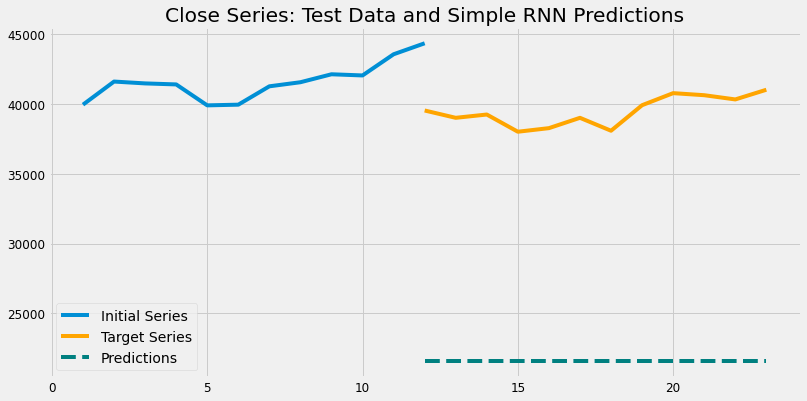

In [38]:
predict_and_plot(test_X, test_y, model,
                 'Close Series: Test Data and Simple RNN Predictions')

It looks like our model is badly underfit and essentially just making constant predictions. That's ok, it was a very simple baseline and trained very quickly. 

We can improve by making the model more expressive, **increasing cell_units**. We can also pass over the training data many more times, **increasing epochs**, giving the model more opportunity to learn the patterns in the data. We'll try that below, it takes a longer time now since our training is more extensive.

Note that there is a significant amount of randomness in neural network training - we may need to retrain the model a few times in order to get
results that we're happy with.

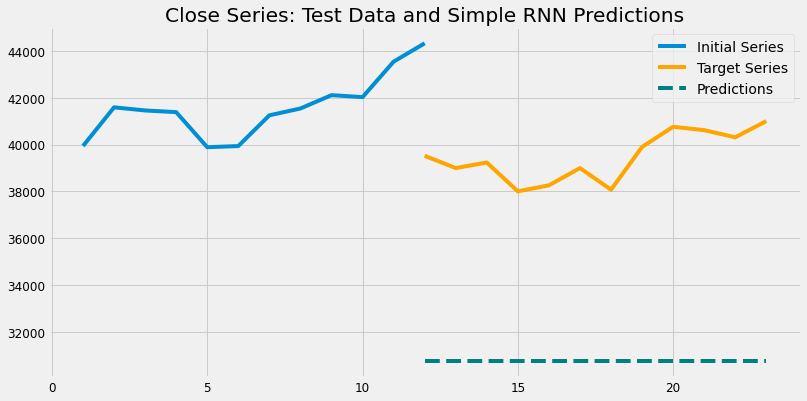

In [40]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X, test_y, model,
                 'Close Series: Test Data and Simple RNN Predictions')



We notice that the performance of the model improved , the predictions values are closer now to the real values

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 30)                960       
                                                                 
 dense_3 (Dense)             (None, 256)               7936      
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25,409
Trainable params: 25,409
Non-trainable params: 0
_________________________________________________________________
